<a href="https://colab.research.google.com/github/kvakhil/Machine-Learning-CS-545/blob/main/Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Neural-Network-Classes" data-toc-modified-id="Neural-Network-Classes-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Neural Network Classes</a></span></li><li><span><a href="#Additional-Required-Functions" data-toc-modified-id="Additional-Required-Functions-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Additional Required Functions</a></span></li><li><span><a href="#Application-to-Three-Data-Sets" data-toc-modified-id="Application-to-Three-Data-Sets-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Application to Three Data Sets</a></span></li><li><span><a href="#Grading" data-toc-modified-id="Grading-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Grading</a></span></li><li><span><a href="#Extra-Credit" data-toc-modified-id="Extra-Credit-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Extra Credit</a></span></li></ul></div>

<font size=10>Neural Networks in Pytorch</font>

In this assignment, you will
1. complete the implementations of neural network classes,
2. define the new function `multiple_runs_classification`,
3. define the new function `multiple_runs_convolutional`,
4. copy and paste `percent_correct` and `confusion_matrx` from previous notes,
4. present and discuss regression results on automobile MPG data,
5. present and discuss classification results on diabetes data,
6. present and discuss classification results on small version of MNIST data.

# Neural Network Classes

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch

For this assignment, start with implementations of the following classes:
* `NeuralNetworkTorch`: copied and pasted from Lecture Notes 16.1
* `NeuralNetworkClassifierTorch`: copied and pasted from Lecture Notes 16.1
* `NeuralNetworkClassifierConvolutionalTorch`: copied and pasted from Lecture Notes 16.1 and completed.

The `train` functions in this classes have two additional arguments, `Xval`nad `Tval`:

```python
   def train(self, Xtrain, Ttrain, n_epochs, learning_rate=0.01, method='adam', verbose=True, 
             Xval=None, Tval=None):
```

where `Xtrain` and `Ttrain` are the usual two arguments used to train the network, and `Xval` and `Tval` are the validation data matrices.  `Xval` and `Tval` are only used to calculate the performance (MSE or NLL) once per epoch.  If the performance is better than the best so far, update an array that is storing the best weight values so far, and also update the best performance so far.  When training is complete, copy the stored best-so-far weights back into the network.  If `Xval` is `None`, then this step is ignored and the weights in the neural network at the end of training are not modified.

# Additional Required Functions

Include in this notebook the following functions we have defined before
* `percent_correct`
* `partition`
* `multiple_runs_regression`

and define two new functions
* `multiple_runs_classification`
* `multiple_runs_convolutional`

based on `multiple_runs_regression`.

In [ ]:
######################################################################
## NeuralNetwork  for regression
######################################################################

class NeuralNetworkTorch(torch.nn.Module):

    def __init__(self, n_inputs, n_hiddens_list, n_outputs, device='cpu'):

        super().__init__()

        self.n_inputs = n_inputs
        self.n_hiddens_list = n_hiddens_list
        self.n_outputs = n_outputs
        self.device = device

        self.n_layers = len(n_hiddens_list) + 1
        
        self.layers = torch.nn.ModuleList()
        for n_units in n_hiddens_list:
            self.layers.append(self._make_tanh_layer(n_inputs, n_units))
            n_inputs = n_units
        self.layers.append(torch.nn.Linear(n_inputs, n_outputs))

        self.stand_params = None
        self.error_trace = []
        self.error_trace_val = []

    def _make_tanh_layer(self, n_inputs, n_units):
        return torch.nn.Sequential(torch.nn.Linear(n_inputs, n_units),
                                   torch.nn.Tanh())

    def __repr__(self):
        return f'NeuralNetworkTorch({self.n_inputs}, {self.n_hiddens_list}, {self.n_outputs}, device={self.device})'

    def forward(self, Xst):
        Ys = [Xst]
        for layer in self.layers:
            Ys.append(layer(Ys[-1]))
        return Ys[1:]  # remove X from Ys

    def train(self, Xtrain, Ttrain, n_epochs=10, learning_rate=0.01, method='adam', verbose=True, Xval=None, Tval=None):

        if isinstance(Xtrain, np.ndarray):
            Xtrain = torch.from_numpy(Xtrain.astype(np.float32))
        if isinstance(Ttrain, np.ndarray):
            Ttrain = torch.from_numpy(Ttrain.astype(np.float32))

        if Xval is not None:
            if isinstance(Xval, np.ndarray):
                Xval = torch.from_numpy(Xval.astype(np.float32))
            if isinstance(Tval, np.ndarray):
                Tval = torch.from_numpy(Tval.astype(np.float32))

        self.stand_params = self.calc_standardize_parameters(Xtrain, Ttrain)
        Xtrain = self.standardize_X(Xtrain)
        Ttrain = self.standardize_T(Ttrain)
        if Xval is not None:
            Xval = self.standardize_X(Xval)
            Tval = self.standardize_T(Tval)

        if method == 'sgd':
            optimizer = torch.optim.SGD(self.parameters(), lr=learning_rate)
        elif method == 'adam':
            optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)
        else:
            print('train: method must be \'sgd\', or \'adam\'.')

        error_f = torch.nn.MSELoss()

        self.best_epoch = None
        best_mse = None
        best_weights = self.get_all_weights()
        
        for epoch in range(n_epochs):

            Ytrain = self.forward(Xtrain)[-1]  # to get last layer output
            mse = error_f(Ytrain, Ttrain)

            optimizer.zero_grad()
            mse.backward()
            optimizer.step()

            self.error_trace.append(mse.sqrt())
            
            if Xval is not None:
                Yval = self.forward(Xval)[-1]
                mse_val = error_f(Yval, Tval)
                self.error_trace_val.append(mse_val.sqrt())
                
                if best_mse is None or mse_val < best_mse:
                    best_mse = mse_val
                    best_weights = self.get_all_weights()
                    self.best_epoch = epoch

            if verbose and ((epoch+1) % (n_epochs // 10) == 0 or epoch == n_epochs - 1):
                if Xval is not None:
                    print(f'Epoch {epoch+1} RMSE train {self.error_trace[-1]:.4f} val {self.error_trace_val[-1]:.4f}')
                else:
                    print(f'Epoch {epoch+1} RMSE {self.error_trace[-1]:.4f}')
                
        if Xval is not None:
            self.set_all_weights(best_weights)

        return self

    def use(self, X, return_hidden_layer_outputs=False):
        if isinstance(X, np.ndarray):
            X = torch.from_numpy(X.astype(np.float32))

        Xst = self.standardize_X(X)
        Ys = self.forward(Xst)
        Y = Ys[-1]
        Y = self.unstandardize_T(Y)
        Zs = Ys[:-1]
        Y = Y.detach().cpu().numpy()
        Zs = [Z.detach().cpu().numpy() for Z in Zs]
        return (Y, Zs) if return_hidden_layer_outputs else Y

    def get_error_trace(self):
        return self.error_trace

    def get_error_traces(self):
        return self.error_trace, self.error_trace_val, self.best_epoch

    def calc_standardize_parameters(self, X, T):
        Xmeans = X.mean(axis=0)
        Xstds = X.std(axis=0)
        Xstds[Xstds == 0] = Xstds[Xstds > 0].mean(axis=0)
        if T is None:
            return {'Xmeans': Xmeans, 'Xstds': Xstds}
        else:
            Tmeans = T.mean(axis=0)
            Tstds = T.std(axis=0)
            return {'Xmeans': Xmeans, 'Xstds': Xstds, 'Tmeans': Tmeans, 'Tstds': Tstds}

    def standardize_X(self, X):
        return (X - self.stand_params['Xmeans']) / self.stand_params['Xstds']

    def unstandardize_X(self, Xst):
        return Xst * self.stand_params['Xstds'] + self.stand_params['Xmeans']

    def standardize_T(self, T):
        return (T - self.stand_params['Tmeans']) / self.stand_params['Tstds']

    def unstandardize_T(self, Tst):
        return Tst * self.stand_params['Tstds'] + self.stand_params['Tmeans']

    def get_Ws(self):
        Ws = []
        for layer in self.layers:
            W_and_bias = list(layer.parameters())
            W = W_and_bias[0].detach().numpy()
            Wbias = W_and_bias[1].detach().numpy().T.reshape(1, -1)
            if W.ndim == 4:
                W = np.moveaxis(W, 0, 3)  # first dim is units. Move it to last, fourth, dim
                n_units = Wbias.shape[-1]
                W = W.reshape(-1, n_units)
            else:
                W = W.T
            Ws.append(np.vstack((Wbias, W)))
        return Ws
        
    def get_all_weights(self):
        return torch.nn.utils.parameters_to_vector(self.parameters())

    def set_all_weights(self, all_weights):
        torch.nn.utils.vector_to_parameters(all_weights, self.parameters())

In [ ]:
######################################################################
## NeuralNetworkClassifierTorch
######################################################################

class NeuralNetworkClassifierTorch(NeuralNetworkTorch):

    def __init__(self, n_inputs, n_hiddens_list, n_outputs, device='cpu'):

        if isinstance(n_inputs, list) or isinstance(n_inputs, tuple):
            # n_inputs might be n_channels, n_rows, n_cols in 2-d input sample
            # if defined for use in a Convolutional network
            super().__init__(np.prod(n_inputs), n_hiddens_list, n_outputs, device)
        else:
            super().__init__(n_inputs, n_hiddens_list, n_outputs, device)

        last_layer = self.layers[-1]
        new_last_layer = torch.nn.Sequential(last_layer,
                                             torch.nn.LogSoftmax(dim=1))  # across columns
        self.layers = self.layers[:-1]
        self.layers.append(new_last_layer)
        # self.layers = self.layers[:-1] + new_last_layer

    def __repr__(self):
        return f'NeuralNetworkClassifierTorch({self.n_inputs}, {self.n_hiddens_list}, {self.n_outputs}, device={self.device})'

    def train(self, Xtrain, Ttrain, n_epochs=10, learning_rate=0.01, method='adam', verbose=True, Xval=None, Tval=None):

        if isinstance(Xtrain, np.ndarray):
            Xtrain = torch.from_numpy(Xtrain.astype(np.float32))
        if isinstance(Ttrain, np.ndarray):
            Ttrain = torch.from_numpy(Ttrain.astype(np.float32))

        if Xval is not None:
            if isinstance(Xval, np.ndarray):
                Xval = torch.from_numpy(Xval.astype(np.float32))
            if isinstance(Tval, np.ndarray):
                Tval = torch.from_numpy(Tval.astype(np.float32))

        Ttrain = Ttrain.long().reshape(-1)  # pytorch expects 1D tensor as labels
        if Xval is not None:
            Tval = Tval.long().reshape(-1)
        
        self.stand_params = self.calc_standardize_parameters(Xtrain, None)
        Xtrain = self.standardize_X(Xtrain)
        if Xval is not None:
            Xval = self.standardize_X(Xval)

        self.classes, counts = Ttrain.unique(return_counts=True)
        self.classes = self.classes.numpy()
        # self.most_common_class = self.classes[np.argmax(counts)]  # not used

        if method == 'sgd':
            optimizer = torch.optim.SGD(self.parameters(), lr=learning_rate)
        elif method == 'adam':
            optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)
        else:
            print('train: method must be \'sgd\', or \'adam\'.')

        neg_log_likelihood = torch.nn.NLLLoss()

        self.best_epoch = None
        best_nll = None
        best_weights = self.get_all_weights()
        
        for epoch in range(n_epochs):

            Ytrain = self.forward(Xtrain)[-1]  # to get last layer output as log(softmax(Y))
            nll = neg_log_likelihood(Ytrain, Ttrain)

            optimizer.zero_grad()
            nll.backward()
            optimizer.step()

            self.error_trace.append((-nll).exp())
            
            if Xval is not None:
                Yval = self.forward(Xval)[-1]
                nll_val = neg_log_likelihood(Yval, Tval)
                self.error_trace_val.append((-nll_val).exp())
                
                if best_nll is None or nll_val < best_nll:
                    best_nll = nll_val
                    best_weights = self.get_all_weights()
                    # print(f'epoch {epoch} first w {best_weights[0]}, nll train {self.error_trace[-1]} val {self.error_trace_val[-1]}')
                    self.best_epoch = epoch

            if verbose and ((epoch+1) % (n_epochs // 10) == 0 or epoch == n_epochs - 1):
                if Xval is not None:
                    print(f'Epoch {epoch+1} LL train {self.error_trace[-1]:.4f} val {self.error_trace_val[-1]:.4f}')
                else:
                    print(f'Epoch {epoch+1} NLL {self.error_trace[-1]:.4f}')

        if Xval is not None:
            # print(f'done epoch {epoch} first w {self.get_all_weights()[0]}')
            self.set_all_weights(best_weights)
            # print(f'after done epoch {epoch} first w {self.get_all_weights()[0]}')

        return self

    def use(self, X, return_hidden_layer_outputs=False):
        if isinstance(X, np.ndarray):
            X = torch.from_numpy(X.astype(np.float32))

        Xst = self.standardize_X(X)
        Ys = self.forward(Xst)
        Y = Ys[-1]
        Zs = Ys[:-1]
        probs = Y.detach().exp().cpu().numpy()  # ex() because net output is log(softmax())
        Zs = [Z.detach().cpu().numpy() for Z in Zs]
        classes = self.classes[np.argmax(probs, axis=1)].reshape(-1, 1)
        return (classes, probs, Zs) if return_hidden_layer_outputs else (classes, probs)

In [ ]:
######################################################################
## NeuralNetworkClassifierConvolutionalTorch
######################################################################

class NeuralNetworkClassifierConvolutionalTorch(NeuralNetworkClassifierTorch):

    def __init__(self, n_inputs, n_conv_list, n_fc_list, n_outputs, device='cpu'):
        '''n_inputs: n_channels X n_rows X n_cols
n_conv_list: list of tuples of (n_units, kernel_size, stride)'''

        # Call constructor, but will discard the layers made and make new ones
        super().__init__(n_inputs, n_fc_list, n_outputs, device)

        self.n_channels, self.n_input_rows, self.n_input_cols = n_inputs
        self.n_conv_list = n_conv_list
        self.n_fc_list = n_fc_list
        self.n_outputs = n_outputs
        self.device = device

        self.layers = torch.nn.ModuleList()
        n_in_channels = self.n_channels
        
        output_rows, output_cols, output_channels = self.n_input_rows, self.n_input_cols, self.n_channels  # COMPLETE THIS
        
        for conv in n_conv_list:
            n_units, kernel_size, stride = conv
            (kernel_rows, kernel_cols) = (kernel_size, kernel_size) if np.isscalar(kernel_size) else kernel_size
            (stride_rows, stride_cols) = (stride, stride) if np.isscalar(stride) else stride

            self.layers.append(self._make_conv_layer(n_in_channels, n_units, kernel_size, stride))
            n_in_channels = n_units

            output_rows, output_cols, output_channels =  ((output_rows-kernel_rows)//stride_rows)+1, ((output_cols-kernel_cols)//stride_cols)+1, n_units  # COMPLETE THIS
            print(output_rows, output_cols,)
        # Add Flatten to output of last convolutional layer
        self.layers[-1].add_module('flatten', torch.nn.Flatten())
        
        # Calculate the total number of inputs entering each unit in the first fully-connected layer
        n_inputs = output_rows * output_cols * output_channels   # COMPLETE THIS

        for n_units in n_fc_list:
            self.layers.append(self._make_tanh_layer(n_inputs, n_units))
            n_inputs = n_units
            
        self.layers.append(torch.nn.Sequential(torch.nn.Linear(n_inputs, n_outputs),
                                               torch.nn.LogSoftmax(dim=1)))  # across columns

    def _make_conv_layer(self, n_in_channels, n_units, kernel_size, stride):
        return torch.nn.Sequential(torch.nn.Conv2d(n_in_channels, n_units, kernel_size, stride),
                                   torch.nn.Tanh())

    def __repr__(self):
        return f'''NeuralNetworkClassifierConvolutionalTorch(n_inputs={self.n_inputs}, n_conv_list={self.n_conv_list}, n_fc_list={self.n_fc_list}, n_outputs={self.n_outputs}, device={self.device})'''

In [ ]:
def partition(X, T, fractions, shuffle=True, classification=False):
    """Usage: Xtrain,Train,Xvalidate,Tvalidate,Xtest,Ttest = partition(X,T,(0.6,0.2,0.2),classification=True)
      X is nSamples x nFeatures.
      fractions can have just two values, for partitioning into train and test only
      If classification=True, T is target class as integer. Data partitioned
        according to class proportions.
        """
    train_fraction = fractions[0]
    if len(fractions) == 2:
        # Skip the validation step
        validate_fraction = 0
        test_fraction = fractions[1]
    else:
        validate_fraction = fractions[1]
        test_fraction = fractions[2]
        
    row_indices = np.arange(X.shape[0])
    if shuffle:
        np.random.shuffle(row_indices)
    
    if not classification:
        # regression, so do not partition according to targets.
        n = X.shape[0]
        n_train = round(train_fraction * n)
        n_validate = round(validate_fraction * n)
        n_test = round(test_fraction * n)
        if n_train + n_validate + n_test > n:
            n_test = n - n_train - n_validate
        Xtrain = X[row_indices[:n_train], :]
        Ttrain = T[row_indices[:n_train], :]
        if n_validate > 0:
            Xvalidate = X[row_indices[n_train:n_train + n_validate], :]
            Tvalidate = T[row_indices[n_train:n_train + n_validate], :]
        Xtest = X[row_indices[n_train + n_validate:n_train + n_validate + n_test], :]
        Ttest = T[row_indices[n_train + n_validate:n_train + n_validate + n_test], :]
        
    else:
        # classifying, so partition data according to target class
        classes = np.unique(T)
        train_indices = []
        validate_indices = []
        test_indices = []
        for c in classes:
            # row indices for class c
            rows_this_class = np.where(T[row_indices,:] == c)[0]
            # collect row indices for class c for each partition
            n = len(rows_this_class)
            n_train = round(train_fraction * n)
            n_validate = round(validate_fraction * n)
            n_test = round(test_fraction * n)
            if n_train + n_validate + n_test > n:
                n_test = n - n_train - n_validate
            train_indices += row_indices[rows_this_class[:n_train]].tolist()
            if n_validate > 0:
                validate_indices += row_indices[rows_this_class[n_train:n_train + n_validate]].tolist()
            test_indices += row_indices[rows_this_class[n_train + n_validate:n_train + n_validate + n_test]].tolist()
        Xtrain = X[train_indices, :]
        Ttrain = T[train_indices, :]
        if n_validate > 0:
            Xvalidate = X[validate_indices, :]
            Tvalidate = T[validate_indices, :]
        Xtest = X[test_indices, :]
        Ttest = T[test_indices, :]
    if n_validate > 0:
        return Xtrain, Ttrain, Xvalidate, Tvalidate, Xtest, Ttest
    else:
        return Xtrain, Ttrain, Xtest, Ttest

In [ ]:
# def percent_correct(p, T):
#     n=0
#     for i in range(len(p)):
#       if(p[i]==T[i]):
#         n+=1
#     return n*100/float(len(T))



In [ ]:
def percent_correct(Ytrain, Ttrain):
    return np.mean(Ytrain[0] == Ttrain) * 100

In [ ]:
def multiple_runs_regression(n_partitions, X, T, fractions, n_hiddens_list, n_epochs, learning_rate):
    
    def rmse(Y, T):
        return np.sqrt(np.mean((T - Y) ** 2))

    print(f'Structure {n_hiddens_list}: Repetition', end=' ')
    results = []
    for rep in range(n_partitions):
        
        print(f'{rep + 1}', end=' ')
        
        Xtrain, Ttrain, Xval, Tval, Xtest, Ttest = partition(X, T, fractions,
                                                             shuffle=True, classification=False)
        
        nnet = NeuralNetworkTorch(X.shape[1], n_hiddens_list, T.shape[1])
        nnet.train(Xtrain, Ttrain, n_epochs, learning_rate, method='adam', Xval=Xval, Tval=Tval, verbose=False)
        
        Ytrain = nnet.use(Xtrain)
        Yval = nnet.use(Xval)
        Ytest = nnet.use(Xtest)
        
        structure = str(n_hiddens_list)
        results.extend([[structure, 'train', rmse(Ytrain, Ttrain)],
                        [structure, 'validation', rmse(Yval, Tval)],
                        [structure, 'test', rmse(Ytest, Ttest)]])
    print()
    return results

Here is another function that you must use to analyze the performance for your two classification problems.

In [ ]:
def confusion_matrix(Y_classes, T):
    class_names = np.unique(T)
    table = []
    for true_class in class_names:
        row = []
        for Y_class in class_names:
            row.append(100 * np.mean(Y_classes[T == true_class] == Y_class))
        table.append(row)
    conf_matrix = pd.DataFrame(table, index=class_names, columns=class_names)
    conf_matrix.style.background_gradient(cmap='Blues').format("{:.1f}")
    print(f'Percent Correct is {percent_correct(Y_classes, T)}')
    return conf_matrix

Here are examples of running `multiple_runs_classification` and `multiple_runs_convolutional`.

In [ ]:
def multiple_runs_classification(n_partitions, X, T, fractions, n_hiddens_list, n_epochs, learning_rate):
    
    

    print(f'Structure {n_hiddens_list}: Repetition', end=' ')
    results = []
    for rep in range(n_partitions):
        
        print(f'{rep + 1}', end=' ')
        
        Xtrain, Ttrain, Xval, Tval, Xtest, Ttest = partition(X, T, fractions,
                                                             shuffle=True, classification=True)
        
      
        
        nnet = NeuralNetworkClassifierTorch(X.shape[1], n_hiddens_list, len(np.unique(T)))
        nnet.train(Xtrain, Ttrain, n_epochs, learning_rate, method='adam', Xval=Xval, Tval=Tval, verbose=False)
        
        Ytrain = nnet.use(Xtrain)
        Yval = nnet.use(Xval)
        Ytest = nnet.use(Xtest)
        
        structure = str(n_hiddens_list)
        results.extend([[structure, 'train', percent_correct(Ytrain, Ttrain)],
                        [structure, 'validation', percent_correct(Yval, Tval)],
                        [structure, 'test', percent_correct(Ytest, Ttest)]])
    print()
    return results

In [ ]:
def multiple_runs_convolutional(n_partitions, X, T, fractions, n_conv, n_hiddens, n_epochs, learning_rate):
    


    print(f'conv {n_conv}  FC: {n_hiddens}, :Repetition', end=' ')
    results = []

    for rep in range(n_partitions):
        
        print(f'{rep + 1}', end=' ')
        
        Xtrain, Ttrain, Xval, Tval, Xtest, Ttest = partition(X, T, fractions,
                                                             shuffle=True, classification=True)
        
        
        nnet = NeuralNetworkClassifierConvolutionalTorch(list(X.shape[1:]), n_conv, n_hiddens, len(np.unique(T)))
        nnet.train(Xtrain, Ttrain, n_epochs, learning_rate, method='adam', Xval=Xval, Tval=Tval, verbose=False)
        
        Ytrain = nnet.use(Xtrain)
        Yval = nnet.use(Xval)
        Ytest = nnet.use(Xtest)
        
        structure = str(n_conv)+' '+str(n_hiddens)
        results.extend([[structure, 'train', percent_correct(Ytrain, Ttrain)],
                        [structure, 'validation', percent_correct(Yval, Tval)],
                        [structure, 'test', percent_correct(Ytest, Ttest)]])

    print()
    return results

In [ ]:
def makeImages(nEach):
    images = np.zeros((nEach * 2, 1, 20, 20))  # nSamples, nChannels, rows, columns
    radii = 3 + np.random.randint(10 - 5, size=(nEach * 2, 1))
    centers = np.zeros((nEach * 2, 2))
    for i in range(nEach * 2):
        r = radii[i, 0]
        centers[i, :] = r + 1 + np.random.randint(18 - 2 * r, size=(1, 2))
        x = int(centers[i, 0])
        y = int(centers[i, 1])
        if i < nEach:
            # squares
            images[i, 0, x - r:x + r, y + r] = 1.0
            images[i, 0, x - r:x + r, y - r] = 1.0
            images[i, 0, x - r, y - r:y + r] = 1.0
            images[i, 0, x + r, y - r:y + r + 1] = 1.0
        else:
            # diamonds
            images[i, 0, range(x - r, x), range(y, y + r)] = 1.0
            images[i, 0, range(x - r, x), range(y, y - r, -1)] = 1.0
            images[i, 0, range(x, x + r + 1), range(y + r, y - 1, -1)] = 1.0
            images[i, 0, range(x, x + r), range(y - r, y)] = 1.0
            # images += np.random.randn(*images.shape) * 0.5
        T = np.zeros((nEach * 2, 1))
        T[nEach:] = 1
    return images, T

nEach = 500
X, T = makeImages(nEach)
Xflat = X.reshape(X.shape[0], -1)
Xflat.shape, T.shape

((1000, 400), (1000, 1))

In [ ]:
import pandas as pd
fractions = (0.6, 0.2, 0.2)
n_hiddens_list = [[], [2], [5], [10], [20, 20]]  # Notice the first one... []
n_epochs = 500
learning_rate = 0.01

n_partitions = 10

results = []
for nh in n_hiddens_list:
    results.extend(multiple_runs_classification(n_partitions, Xflat, T, fractions, nh, n_epochs, learning_rate))
    
resultsdf = pd.DataFrame(results, columns=('Structure', 'Partition', 'RMSE'))

Structure []: Repetition 1 2 3 4 5 6 7 8 9 10 
Structure [2]: Repetition 1 2 3 4 5 6 7 8 9 10 
Structure [5]: Repetition 1 2 3 4 5 6 7 8 9 10 
Structure [10]: Repetition 1 2 3 4 5 6 7 8 9 10 
Structure [20, 20]: Repetition 1 2 3 4 5 6 7 8 9 10 


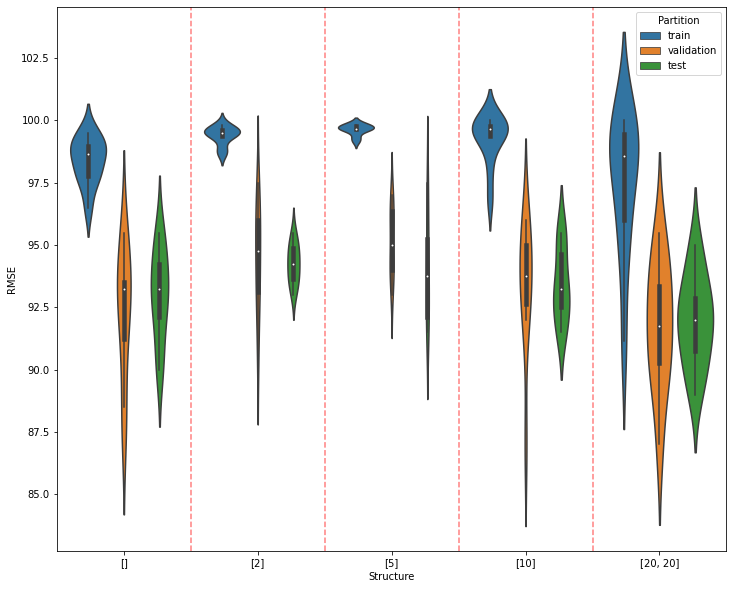

In [ ]:
import seaborn as sns

plt.figure(figsize=(12, 10))
sns.violinplot(x='Structure', y='RMSE', hue='Partition', data=resultsdf)
for x in range(len(n_hiddens_list) - 1):
    plt.axvline(x + 0.5, color='r', linestyle='--', alpha=0.5)

Based on results in violin plots, pick best network structure (according to performance in validation data) and train a network using that structure.  Then apply the trained network using `nnet.use` on the training, validation and testing partitions.  Report the performance of each, and, for classification problems, show the confusion matrices.  See examples below.

In [ ]:
nnet = NeuralNetworkClassifierTorch(Xflat.shape[1], [10], len(np.unique(T)))
Xtrain, Ttrain, Xval, Tval, Xtest, Ttest = partition(Xflat, T, (0.6, 0.2, 0.2),
                                         shuffle=True, classification=True)
nnet.train(Xtrain, Ttrain, n_epochs, learning_rate, method='adam', Xval=Xval, Tval=Tval, verbose=True)

Epoch 50 LL train 0.9947 val 0.8074
Epoch 100 LL train 0.9983 val 0.7817
Epoch 150 LL train 0.9989 val 0.7671
Epoch 200 LL train 0.9992 val 0.7547
Epoch 250 LL train 0.9994 val 0.7442
Epoch 300 LL train 0.9995 val 0.7349
Epoch 350 LL train 0.9996 val 0.7264
Epoch 400 LL train 0.9997 val 0.7195
Epoch 450 LL train 0.9997 val 0.7140
Epoch 500 LL train 0.9998 val 0.7090


NeuralNetworkClassifierTorch(400, [10], 2, device=cpu)

In [ ]:
C_train, P_train = nnet.use(Xtrain)
confusion_matrix(C_train, Ttrain)

Percent Correct is 50.0


,0.0,1.0
0.0,99.333333,0.666667
1.0,0.000000,100.000000


In [ ]:
C_val, P_val = nnet.use(Xval)
confusion_matrix(C_val, Tval)

Percent Correct is 50.0


,0.0,1.0
0.0,92.0,8.0
1.0,0.0,100.0


In [ ]:
C_test, P_test = nnet.use(Xtest)
confusion_matrix(C_test, Ttest)

Percent Correct is 50.0


,0.0,1.0
0.0,87.0,13.0
1.0,1.0,99.0


In [ ]:
fractions = (0.6, 0.2, 0.2)
n_conv_list = [ [(5, (3, 3), (1, 1))],
                [(5, (3, 3), (1, 1)), (4, (4, 4), (2, 2))]
              ]
n_fc_list = [[], [5], [10, 10]]  # Notice the first one... []
n_epochs = 200
learning_rate = 0.01

n_partitions = 10

results = []
for nconv in n_conv_list:
    for nfc in n_fc_list:
        results.extend(multiple_runs_convolutional(n_partitions, X, T, fractions, nconv, nfc, n_epochs, learning_rate))
    
resultsdf = pd.DataFrame(results, columns=('Structure', 'Partition', 'RMSE'))

conv [(5, (3, 3), (1, 1))]  FC: [], :Repetition 1 18 18
2 18 18
3 18 18
4 18 18
5 18 18
6 18 18
7 18 18
8 18 18
9 18 18
10 18 18

conv [(5, (3, 3), (1, 1))]  FC: [5], :Repetition 1 18 18
2 18 18
3 18 18
4 18 18
5 18 18
6 18 18
7 18 18
8 18 18


KeyboardInterrupt: ignored

In [ ]:
import seaborn as sns

plt.figure(figsize=(15, 10))
sns.violinplot(x='Structure', y='RMSE', hue='Partition', data=resultsdf)
plt.xticks(rotation=10)

for x in range(len(n_conv_list) * len(n_fc_list) - 1):
    plt.axvline(x + 0.5, color='r', linestyle='--', alpha=0.5)

# Application to Three Data Sets

In the following experiments, you may try a variety of learning_rates, numbers of epochs, and network structures, but in the violin plot use one value for learning_rate, one value for number of epochs, and six values of network structure.

Apply `multiple_runs_regression` for various network structures to the automobile data introduced in Lecture Notes 17.  Load it as follows.

In [ ]:
import pandas as pd
import os

if os.path.isfile('automobile.csv'):
    print('Reading data from \'automobile.csv\'.')
    automobile = pd.read_csv('automobile.csv')
else:
    print('Downloading auto-mpg.data from UCI ML Repository.')
    automobile = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data',
                             header=None, delimiter='\s+', na_values='?', 
                             usecols=range(8))
    automobile.columns = ('mpg', 'cylinders', 'displacement', 'horsepower', 'weight',
                          'acceleration', 'year', 'origin')

    print(f'Number rows in original data file {len(automobile)}.')
    automobile = automobile.dropna(axis=0)
    print(f'Number rows after dropping rows with missing values {len(automobile)}.')
    automobile.to_csv('automobile.csv', index=False)  # so row numbers are not written to file
    
T = automobile['mpg'].values.reshape(-1, 1)
X = automobile.iloc[:, 1:].values
X.shape, T.shape

Reading data from 'automobile.csv'.


((392, 7), (392, 1))

In [ ]:
fractions = (0.6, 0.2, 0.2)


n_hiddens_list = [[], [7], [15, 20],[20,10,5],[200,150,100,50]]  # Notice the first one... []
n_epochs = 350
learning_rate = 0.001

n_partitions = 10

results = []
for nfc in n_hiddens_list:
    results.extend(multiple_runs_regression(n_partitions, X, T, fractions, nfc, n_epochs, learning_rate))
    
resultsdf = pd.DataFrame(results, columns=('Structure', 'Partition', 'RMSE'))

Structure []: Repetition 1 2 3 4 5 6 7 8 9 10 
Structure [7]: Repetition 1 2 3 4 5 6 7 8 9 10 
Structure [15, 20]: Repetition 1 2 3 4 5 6 7 8 9 10 
Structure [20, 10, 5]: Repetition 1 2 3 4 5 6 7 8 9 10 
Structure [200, 150, 100, 50]: Repetition 1 2 3 4 5 6 7 8 9 10 


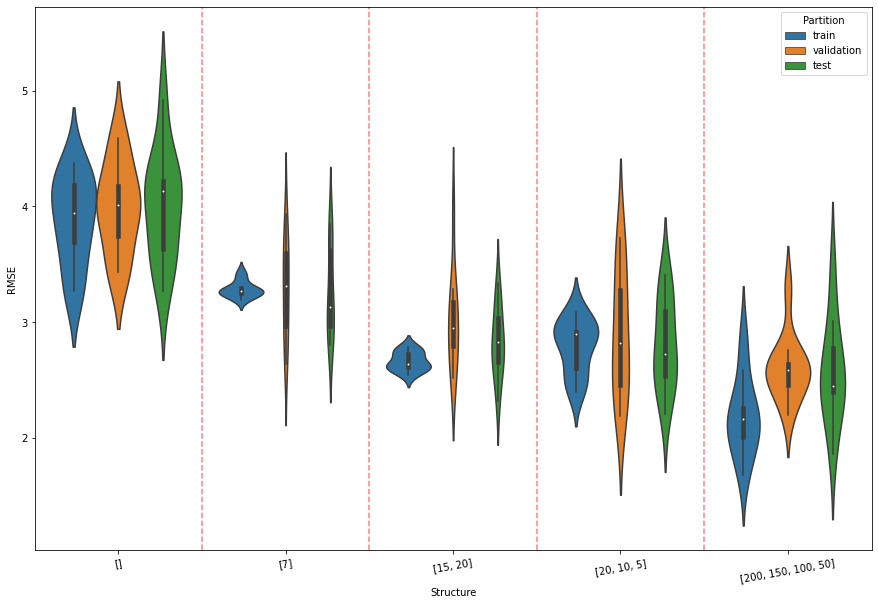

In [ ]:
import seaborn as sns

plt.figure(figsize=(15, 10))
sns.violinplot(x='Structure', y='RMSE', hue='Partition', data=resultsdf)
plt.xticks(rotation=10)

for x in range(len(n_hiddens_list) - 1):
    plt.axvline(x + 0.5, color='r', linestyle='--', alpha=0.5)

# Best Model

In [ ]:
fractions = (0.6, 0.2, 0.2)


n_hiddens_list = [[200,150,100,50]]  # Notice the first one... []
n_epochs = 300
learning_rate = 0.001

n_partitions = 10

results = []
for nfc in n_hiddens_list:
    results.extend(multiple_runs_regression(n_partitions, X, T, fractions, nfc, n_epochs, learning_rate))
    
resultsdf = pd.DataFrame(results, columns=('Structure', 'Partition', 'RMSE'))
resultsdf

Structure [200, 150, 100, 50]: Repetition 1 2 3 4 5 6 7 8 9 10 


,Structure,Partition,RMSE
0,"[200, 150, 100, 50]",train,1.957871
1,"[200, 150, 100, 50]",validation,2.836244
2,"[200, 150, 100, 50]",test,2.734421
3,"[200, 150, 100, 50]",train,2.249557
4,"[200, 150, 100, 50]",validation,2.653910
5,"[200, 150, 100, 50]",test,2.850211
6,"[200, 150, 100, 50]",train,2.489548
7,"[200, 150, 100, 50]",validation,2.471943
8,"[200, 150, 100, 50]",test,2.743511
9,"[200, 150, 100, 50]",train,3.153443


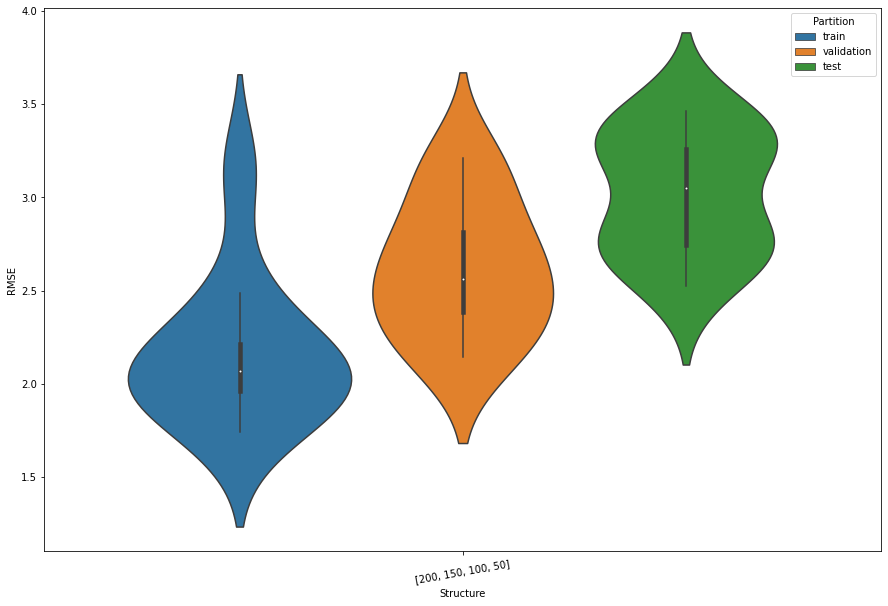

In [ ]:
import seaborn as sns

plt.figure(figsize=(15, 10))
sns.violinplot(x='Structure', y='RMSE', hue='Partition', data=resultsdf)
plt.xticks(rotation=10)

for x in range(len(n_hiddens_list) - 1):
    plt.axvline(x + 0.5, color='r', linestyle='--', alpha=0.5)

# Obsesrvation for regression violin plots

*   We know that, the lower the RMSE the better is the model's performance. In these violin plots we can see that the model with 4 hidden layers has the best train, validation and test RMSE values.
*   As the number of layers are increased the density of the values of the center are increasing and the RMSE values are decreasing. We can also see that the range of the RMSE values is decreasing.

*   The linear model perfomrs the worst with the test RMSE close to 5%.
*   One interesting thing to see is that the best model, even though it has low RMSE it has an uneven shape. The range of the values is also high. This could be improved by in opinion by increasing the number of epochs





Apply `multiple_runs_classification` for various network structures to the following data set from a study in diabetes diagnosis.

In [ ]:
if os.path.isfile('diabetes.csv'):
    print('Reading data from \'diabetes.csv\'.')
    diabetes = pd.read_csv('diabetes.csv')
else:
    print('Downloading diabetes_data_upload.csv from UCI ML Repository.')
    diabetes = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00529/diabetes_data_upload.csv')
                        # usecols=range(1,14))
    if False:
        print(f'Number rows in original data file {len(diabetes)}.')
        diabetes = diabetes.dropna(axis=0)
        print(f'Number rows after dropping rows with missing values {len(diabetes)}.')
    converter = dict(Yes=1, No=0, Female=1, Male=0, Positive=1, Negative=0)
    diabetes = diabetes.applymap(lambda x: converter.get(x, x))
    diabetes.to_csv('diabetes.csv', index=False)  # so row numbers are not written to file

X = diabetes.iloc[:, :-1].values
T = diabetes.iloc[:, -1:].values

X.shape, T.shape

Reading data from 'diabetes.csv'.


((520, 16), (520, 1))

In [ ]:
fractions = (0.6, 0.2, 0.2)
n_hiddens_list = [[], [5], [20], [20, 10],[15,15,20]]  # Notice the first one... []
n_epochs = 350
learning_rate = 0.01

n_partitions = 10

results = []
for n_hiddens in n_hiddens_list:
    results.extend(multiple_runs_classification(n_partitions, X,T, fractions, n_hiddens, n_epochs, learning_rate))
    
resultsdf = pd.DataFrame(results, columns=('Structure', 'Partition', 'Percent_correct'))

Structure []: Repetition 1 2 3 4 5 6 7 8 9 10 
Structure [5]: Repetition 1 2 3 4 5 6 7 8 9 10 
Structure [20]: Repetition 1 2 3 4 5 6 7 8 9 10 
Structure [20, 10]: Repetition 1 2 3 4 5 6 7 8 9 10 
Structure [15, 15, 20]: Repetition 1 2 3 4 5 6 7 8 9 10 


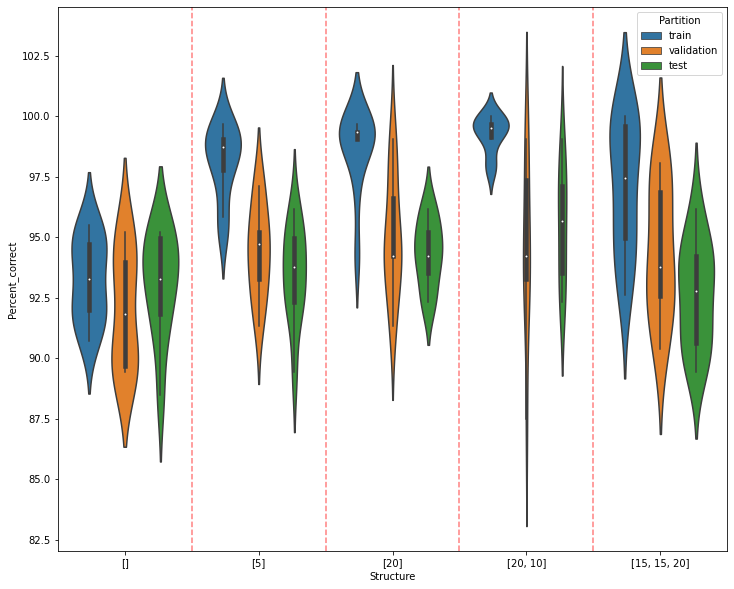

In [ ]:
import seaborn as sns

plt.figure(figsize=(12, 10))
sns.violinplot(x='Structure', y='Percent_correct', hue='Partition', data=resultsdf)
for x in range(len(n_hiddens_list) - 1):
    plt.axvline(x + 0.5, color='r', linestyle='--', alpha=0.5)

# BEST MODEL

In [ ]:
fractions = (0.6, 0.2, 0.2)
n_hiddens_list = [[20,10]]  # Notice the first one... []
n_epochs = 350
learning_rate = 0.01

n_partitions = 10

results = []
for nh in n_hiddens_list:
    results.extend(multiple_runs_classification(n_partitions, X,T, fractions, nh, n_epochs, learning_rate))
    
resultsdf = pd.DataFrame(results, columns=('Structure', 'Partition', 'Percent_correct'))

Structure [20, 10]: Repetition 1 2 3 4 5 6 7 8 9 10 


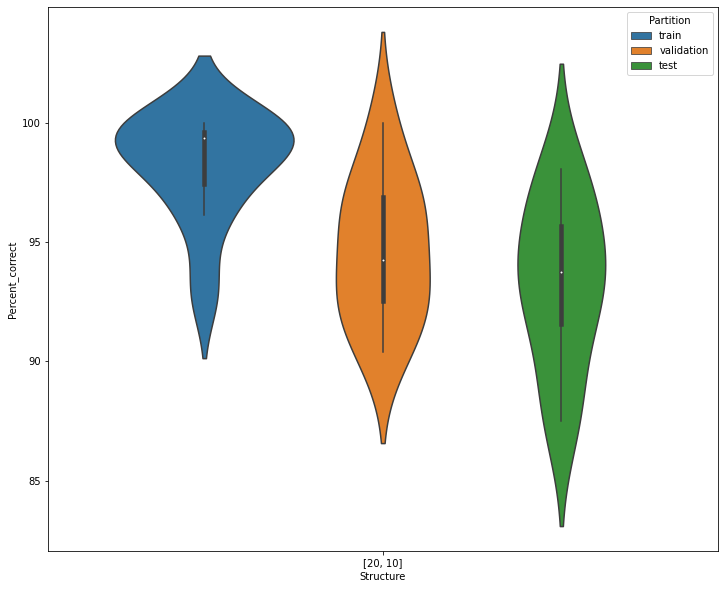

In [ ]:
import seaborn as sns

plt.figure(figsize=(12, 10))
sns.violinplot(x='Structure', y='Percent_correct', hue='Partition', data=resultsdf)
for x in range(len(n_hiddens_list) - 1):
    plt.axvline(x + 0.5, color='r', linestyle='--', alpha=0.5)

# Confusion Matrix

In [ ]:
nnet = NeuralNetworkClassifierTorch(X.shape[1], [20,10], len(np.unique(T)))
Xtrain, Ttrain, Xval, Tval, Xtest, Ttest = partition(X, T, (0.6, 0.2, 0.2),
                                         shuffle=True, classification=True)
nnet.train(Xtrain, Ttrain, n_epochs, learning_rate, method='adam', Xval=Xval, Tval=Tval, verbose=True)

Epoch 35 LL train 0.8640 val 0.8636
Epoch 70 LL train 0.9694 val 0.9381
Epoch 105 LL train 0.9934 val 0.9296
Epoch 140 LL train 0.9955 val 0.9272
Epoch 175 LL train 0.9967 val 0.9224
Epoch 210 LL train 0.9976 val 0.9146
Epoch 245 LL train 0.9982 val 0.9070
Epoch 280 LL train 0.9987 val 0.9000
Epoch 315 LL train 0.9990 val 0.8935
Epoch 350 LL train 0.9993 val 0.8878


NeuralNetworkClassifierTorch(16, [20, 10], 2, device=cpu)

In [ ]:
C_train, P_train = nnet.use(Xtrain)
confusion_matrix(C_train, Ttrain)

Percent Correct is 38.46153846153847


,0,1
0,99.166667,0.833333
1,0.000000,100.000000


In [ ]:
C_val, P_val = nnet.use(Xval)
confusion_matrix(C_val, Tval)

Percent Correct is 38.46153846153847


,0,1
0,95.0000,5.0000
1,1.5625,98.4375


In [ ]:
C_test, P_test = nnet.use(Xtest)
confusion_matrix(C_test, Ttest)

Percent Correct is 38.46153846153847


,0,1
0,100.000,0.000
1,9.375,90.625


# Obsesrvations for Classification

*   The best model has about 95% accuracy which is for the model with two hidden layers but it as a very high range. Like always the linear model performs the worst.

*   As the number of layers are increased there is no significant change in train accuracy but the test accuracy differs significantly.

*   The model with single hidden layer with 5 units has accuracy lose to the best model and also it has lesser range of percent_correct values.



Apply `multiple_runs_convolutional` for various network structures to the following small subset of the MNIST data that contains 500 samples of each digit.

In [ ]:
if os.path.isfile('small_mnist.npz'):
    print('Reading data from \'small_mnist.npz\'.')
    small_mnist = np.load('small_mnist.npz')
else:
    import shlex
    import subprocess
    print('Downloading small_mnist.npz from CS545 site.')
    cmd = 'curl "https://www.cs.colostate.edu/~anderson/cs545/notebooks/small_mnist.npz" -o "small_mnist.npz"'
    subprocess.call(shlex.split(cmd))
    small_mnist = np.load('small_mnist.npz')


X = small_mnist['X']
X = X.reshape(-1, 1, 28, 28)
T = small_mnist['T']

X.shape, T.shape

Reading data from 'small_mnist.npz'.


((1000, 1, 28, 28), (1000, 1))

In [ ]:
fractions = (0.6, 0.2, 0.2)
n_conv_list = [ [(5, (3, 3), (1, 1))], 
               [(10, (4, 4), (1, 1)), (4, (4, 4), (2, 2))],
                [(10, (4, 4), (2, 2)), (5, (3, 3), (2, 2)), (4, (4, 4), (2, 2))]
               ]
n_hiddens_list = [[], [7], [15,10]]  # Notice the first one... []
n_epochs = 350
learning_rate = 0.01

n_partitions = 10

results = []
for nconv in n_conv_list:
    for n_hiddens in n_hiddens_list:
        results.extend(multiple_runs_convolutional(n_partitions, X, T, fractions, nconv, n_hiddens, n_epochs, learning_rate))
    
resultsdf = pd.DataFrame(results, columns=('Structure', 'Partition', 'RMSE'))

conv [(5, (3, 3), (1, 1))]  FC: [], :Repetition 1 26 26
2 26 26
3 26 26
4 26 26
5 26 26
6 26 26
7 26 26
8 26 26
9 26 26
10 26 26

conv [(5, (3, 3), (1, 1))]  FC: [7], :Repetition 1 26 26
2 26 26
3 26 26
4 26 26
5 26 26
6 26 26
7 26 26
8 26 26
9 26 26
10 26 26

conv [(5, (3, 3), (1, 1))]  FC: [15, 10], :Repetition 1 26 26
2 26 26
3 26 26
4 26 26
5 26 26
6 26 26
7 26 26
8 26 26
9 26 26
10 26 26

conv [(10, (4, 4), (1, 1)), (4, (4, 4), (2, 2))]  FC: [], :Repetition 1 25 25
11 11
2 25 25
11 11
3 25 25
11 11
4 25 25
11 11
5 25 25
11 11
6 25 25
11 11
7 25 25
11 11
8 25 25
11 11
9 25 25
11 11
10 25 25
11 11

conv [(10, (4, 4), (1, 1)), (4, (4, 4), (2, 2))]  FC: [7], :Repetition 1 25 25
11 11
2 25 25
11 11
3 25 25
11 11
4 25 25
11 11
5 25 25
11 11
6 25 25
11 11
7 25 25
11 11
8 25 25
11 11
9 25 25
11 11
10 25 25
11 11

conv [(10, (4, 4), (1, 1)), (4, (4, 4), (2, 2))]  FC: [15, 10], :Repetition 1 25 25
11 11
2 25 25
11 11
3 25 25
11 11
4 25 25
11 11
5 25 25
11 11
6 25 25
11 11
7 25 25
11 11
8 25

KeyboardInterrupt: ignored

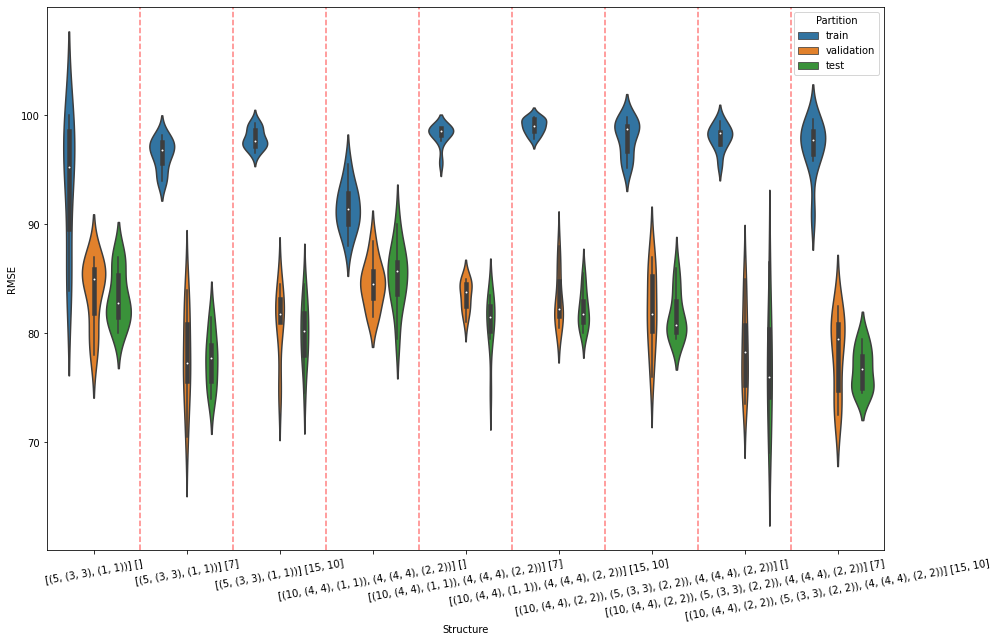

In [ ]:
import seaborn as sns

plt.figure(figsize=(15, 10))
sns.violinplot(x='Structure', y='RMSE', hue='Partition', data=resultsdf)
plt.xticks(rotation=10)

for x in range(len(n_conv_list) * len(n_hiddens_list) - 1):
    plt.axvline(x + 0.5, color='r', linestyle='--', alpha=0.5)

# Best Model

In [ ]:
fractions = (0.6, 0.2, 0.2)
n_conv_list = [ [(10, (4, 4), (1, 1)), (4, (4, 4), (2, 2))]]
n_fc_list = [[]]  # Notice the first one... []
n_epochs = 350
learning_rate = 0.01

n_partitions = 10

results = []
for nconv in n_conv_list:
    for nfc in n_fc_list:
        results.extend(multiple_runs_convolutional(n_partitions, X, T, fractions, nconv, nfc, n_epochs, learning_rate))
    
resultsdf = pd.DataFrame(results, columns=('Structure', 'Partition', 'percent_correct'))

conv [(10, (4, 4), (1, 1)), (4, (4, 4), (2, 2))]  FC: [], :Repetition 1 25 25
11 11
2 25 25
11 11
3 25 25
11 11
4 25 25
11 11
5 25 25
11 11
6 25 25
11 11
7 25 25
11 11
8 25 25
11 11
9 25 25
11 11
10 25 25
11 11



# Confusion Matrix

In [ ]:
nnet = NeuralNetworkClassifierConvolutionalTorch(list(X.shape[1:]),[(10, (4, 4), (1, 1)), (4, (4, 4), (2, 2))], [10], len(np.unique(T)))
Xtrain, Ttrain, Xval, Tval, Xtest, Ttest = partition(X, T, (0.6, 0.2, 0.2),
                                         shuffle=True, classification=True)
nnet.train(Xtrain, Ttrain, n_epochs, learning_rate, method='adam', Xval=Xval, Tval=Tval, verbose=True)

25 25
11 11
Epoch 35 LL train 0.6921 val 0.5308
Epoch 70 LL train 0.8704 val 0.6239
Epoch 105 LL train 0.9230 val 0.6524
Epoch 140 LL train 0.9421 val 0.6736
Epoch 175 LL train 0.9601 val 0.6753
Epoch 210 LL train 0.9692 val 0.6842
Epoch 245 LL train 0.9742 val 0.6907
Epoch 280 LL train 0.9778 val 0.6944
Epoch 315 LL train 0.9813 val 0.6859
Epoch 350 LL train 0.9836 val 0.6832


NeuralNetworkClassifierConvolutionalTorch(n_inputs=784, n_conv_list=[(10, (4, 4), (1, 1)), (4, (4, 4), (2, 2))], n_fc_list=[10], n_outputs=10, device=cpu)

In [ ]:
C_train, P_train = nnet.use(Xtrain)
confusion_matrix(C_train, Ttrain)

Percent Correct is 10.0


,0,1,2,3,4,5,6,7,8,9
0,100.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,100.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.0,96.666667,0.000000,0.000000,1.666667,0.000000,1.666667,0.000000,0.000000
3,0.000000,0.0,1.666667,98.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.0,0.000000,0.000000,98.333333,0.000000,0.000000,0.000000,0.000000,1.666667
5,0.000000,0.0,0.000000,1.666667,1.666667,96.666667,0.000000,0.000000,0.000000,0.000000
6,1.666667,0.0,0.000000,0.000000,1.666667,0.000000,96.666667,0.000000,0.000000,0.000000
7,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,100.000000,0.000000,0.000000
8,0.000000,0.0,0.000000,0.000000,0.000000,1.666667,0.000000,0.000000,98.333333,0.000000
9,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,3.333333,0.000000,96.666667


In [ ]:
C_val, P_val = nnet.use(Xval)
confusion_matrix(C_val, Tval)

Percent Correct is 10.0


,0,1,2,3,4,5,6,7,8,9
0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,85.0,0.0,5.0,0.0,5.0,5.0,0.0,0.0,0.0
2,0.0,5.0,80.0,0.0,5.0,0.0,0.0,5.0,5.0,0.0
3,0.0,0.0,5.0,80.0,0.0,5.0,5.0,0.0,5.0,0.0
4,0.0,0.0,0.0,0.0,95.0,0.0,5.0,0.0,0.0,0.0
5,0.0,0.0,5.0,15.0,0.0,60.0,10.0,5.0,5.0,0.0
6,5.0,0.0,0.0,0.0,0.0,5.0,90.0,0.0,0.0,0.0
7,0.0,5.0,0.0,0.0,0.0,0.0,0.0,95.0,0.0,0.0
8,0.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,90.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,85.0


In [ ]:
C_test, P_test = nnet.use(Xtest)
confusion_matrix(C_test, Ttest)

Percent Correct is 10.0


,0,1,2,3,4,5,6,7,8,9
0,90.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,5.0,0.0
1,0.0,85.0,0.0,0.0,0.0,5.0,5.0,5.0,0.0,0.0
2,5.0,0.0,75.0,5.0,5.0,0.0,5.0,0.0,0.0,5.0
3,0.0,0.0,0.0,85.0,0.0,5.0,0.0,5.0,5.0,0.0
4,0.0,0.0,0.0,0.0,95.0,0.0,5.0,0.0,0.0,0.0
5,0.0,0.0,0.0,10.0,10.0,75.0,5.0,0.0,0.0,0.0
6,0.0,5.0,0.0,0.0,0.0,0.0,90.0,0.0,0.0,5.0
7,0.0,10.0,0.0,0.0,0.0,0.0,0.0,90.0,0.0,0.0
8,0.0,5.0,5.0,0.0,0.0,5.0,0.0,0.0,85.0,0.0
9,10.0,0.0,0.0,0.0,10.0,0.0,0.0,5.0,5.0,70.0


# Observations for Convolutional


*   From the violin graph, we can see that the best test percent_correct is more than 85%  given by the network with two convolutional layers but not hidden layers. This is very interesting because, the same structure gives the worst train accuracy. 

*   Increasing the number of hidden layers is increasing the train accuracy but decreasing the test accuracy. This could be suggesting that the increasing the hidden layers is leading to overfitting to a certain extent. 


*   The worst accuracy is below 80% given by the network with 3 convolutional layers and no hidden layers. The train accuracies are vastly better than the test and  validation accuracies in most of the models and the validation and test accuracies are very close.

  





For each of the three applications, make violin plots.  For classification problems, also show the confusion matrices.  Describe the results you see with at least 10 sentences for each application, for a total of at least 30 sentences.

# Grading

Download [A5grader.tar](https://www.cs.colostate.edu/~anderson/cs545/notebooks/A5grader.tar), extract `A5grader.py` before running the following cell.

In [ ]:
%run -i A5grader.py


======================= Code Execution =======================

Extracting python code from notebook named 'kakumanu-A5.ipynb' and storing in notebookcode.py
Removing all statements that are not function or class defs or import statements.

## Testing constructor ####################################################################

    nnet = NeuralNetworkClassifierConvolutionalTorch([1, 10, 10], 
                                                     [(2, (3, 3), (1, 1)), (3, (5, 5), (2, 2))],
                                                     [30, 20], 2)

    # Is isinstance(nnet, NeuralNetworkClassifierTorch)   True?

8 8
2 2

--- 10/10 points. NeuralNetworkClassifierConvolutionalTorch is correctly of type NeuralNetworkClassifierTorch

--- 10/10 points. nnet correctly has 5 pytorch layers.

## Testing train ####################################################################

    np.random.seed(42)
    X = np.random.uniform(0, 1, size=(100, 2))
    T = (np.abs(X[:, 0:1] - X[:, 1:2

<Figure size 432x288 with 0 Axes>

# Extra Credit

Try to train on a GPU for at least one of the datasets by calling one of the `multiple_runs_...` functions.  A simple guide to changes you will need in your code is available at [this site](https://towardsdatascience.com/pytorch-switching-to-the-gpu-a7c0b21e8a99).  You may run on one of the CS department's workstations that have GPUs.

Discuss the execution time on just the CPU and on a GPU.  